In [1]:
"""Script to generate the results for the literature review.
"""

import utils as ut
import analysis as anl

df = ut.load_data_items()
results_df = ut.load_reported_results_data()
ut.check_data_items(df)


In [2]:
import os
import logging
import logging.config
from collections import OrderedDict
import subprocess

import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib as mpl
import seaborn as sns
import numpy as np
from PIL import Image


In [3]:
data_df = ut.split_column_with_multiple_entries(
    df, ['Data - samples', 'Data - time'], ref_col=['Citation', 'Main domain', 'Features (clean)'], 
    sep=';\n', lower=False)

# Remove N/M and TBD
col = 'Data - samples'
data_df.loc[data_df[col].isin(['N/M', 'TBD', '[TBD]']), col] = np.nan
data_df[col] = data_df[col].astype(float)

col2 = 'Data - time'
data_df.loc[data_df[col2].isin(['N/M', 'TBD', '[TBD]']), col2] = np.nan
data_df[col2] = data_df[col2].astype(float)

# Wrap main domain text
data_df['Main domain'] = data_df['Main domain'].apply(
    ut.wrap_text, max_char=13)

# Extract ratio
data_df['data_ratio'] = data_df['Data - samples'] / data_df['Data - time']
data_df = data_df.sort_values(['Main domain', 'data_ratio'])

acc_df = results_df[results_df['Metric'] == 'accuracy']  # Extract accuracy rows only

# Create new column that contains both citation and task information
acc_df.loc[:, 'citation_task'] = acc_df[['Citation', 'Task']].apply(
    lambda x: ' ['.join(x) + ']', axis=1)

# Create a new column with the year
acc_df.loc[:, 'year'] = acc_df['Citation'].apply(
    lambda x: int(x[x.find('2'):x.find('2') + 4]))

acc_df_best_proposed = acc_df[acc_df['model_type'] == 'Proposed'].sort_values('Result', ascending=False).drop_duplicates('Citation')
acc_df_best_baseline_trad = acc_df[acc_df['model_type'] == 'Baseline (traditional)'].sort_values('Result', ascending=False).drop_duplicates('Citation')

acc_df_best_proposed = acc_df_best_proposed[acc_df_best_proposed['Citation'].isin(acc_df_best_baseline_trad['Citation'])]
acc_df_best_baseline_trad = acc_df_best_baseline_trad[acc_df_best_baseline_trad['Citation'].isin(acc_df_best_proposed['Citation'])]

acc_df_best_proposed = acc_df_best_proposed.sort_values('Citation')
acc_df_best_baseline_trad = acc_df_best_baseline_trad.sort_values('Citation')
acc_df_best_baseline_trad.index = acc_df_best_baseline_trad['Citation']
acc_df_best_proposed.index = acc_df_best_proposed['Citation']

acc_diff = pd.DataFrame({
    'Difference': acc_df_best_proposed['Result'] - acc_df_best_baseline_trad['Result'],
    'Citation': acc_df_best_baseline_trad.index
}).reset_index(drop=True)
acc_diff = acc_diff[acc_diff['Difference'] < 0.7]

data_df = pd.merge(data_df, acc_diff, on='Citation')
data_df = data_df.dropna()

/home/maciej/src/dl-eeg-review/code/utils.py:106: UserWarning: 1 rows had incompatible numbers of elements in the columns of interest and were dropped:
  warnings.warn('{} rows had incompatible numbers of elements in the '
/home/maciej/src/dl-eeg-review/code/utils.py:110: UserWarning: 	Morabito2016
  warnings.warn('\t{}'.format(df.iloc[i].loc['Citation']))
/tmp/ipykernel_74404/685501953.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_df.loc[:, 'citation_task'] = acc_df[['Citation', 'Task']].apply(
/tmp/ipykernel_74404/685501953.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [4]:
# import config as cfg
# import utils as ut


# # Set style, context and palette
# sns.set_style(rc=cfg.axes_styles)
# sns.set_context(rc=cfg.plotting_context)
# sns.set_palette(cfg.palette)

# for key, val in cfg.axes_styles.items():
#     mpl.rcParams[key] = val
# for key, val in cfg.plotting_context.items():
#     mpl.rcParams[key] = val

In [5]:
# save_cfg = cfg.saving_config

In [4]:
%matplotlib inline

In [5]:
from scipy.stats import binned_statistic

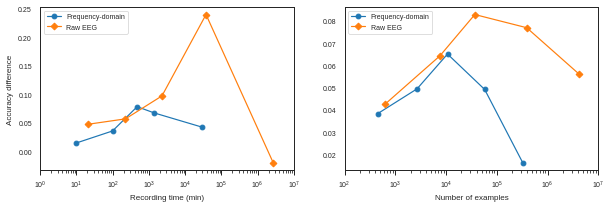

In [25]:
fig, axes = plt.subplots(
    ncols=2, figsize=(10, 3))
#     figsize=(save_cfg['text_width'], save_cfg['text_height'] / 3))
# axes = [axes]

axes[0].set(xscale='log', yscale='linear')

for features, marker in zip([['Frequency-domain'], ['Raw EEG']], ['o', 'D']):
    
    x = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        statistic="mean", bins=5)[0]).dropna()
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="mean", bins=5)[0]).dropna()
    axes[0].plot(x, y, f'{marker}-', label=features[0])
axes[0].legend()
max_val = int(np.ceil(np.log10(data_df[col2].max())))
axes[0].set_xticks(np.power(10, range(0, max_val + 1)))
axes[0].set_xlabel('Recording time (min)')
axes[0].set_ylabel('Accuracy difference')

axes[1].set(xscale='log', yscale='linear')

for features, marker in zip([['Frequency-domain'], ['Raw EEG']], ['o', 'D']):
    
    x = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
        statistic="mean", bins=5)[0]).dropna()
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="mean", bins=5)[0]).dropna()
    axes[1].plot(x, y, f'{marker}-', label=features[0])
axes[1].legend()
min_val = int(np.floor(np.log10(x.min())))
max_val = int(np.ceil(np.log10(x.max())))
axes[1].set_xticks(np.power(10, range(min_val, max_val + 1)))
axes[1].set_xlabel('Number of examples')
plt.savefig('../figs/dataset_size_vs_acc.png', dpi=350)